# Imports

In [1]:
import os
from typing import Any, Union
from pathlib import Path
import sys
import subprocess

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
import torch
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.calibration import LabelEncoder
import sklearn
import transformers

repo_dir = Path(subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip())
data_dir = repo_dir / "data"
sys.path.append(str(repo_dir))
from src import bert, train, optim, engine

plt.style.use('Solarize_Light2')
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

%load_ext autoreload
%autoreload 2

# Data

In [2]:
data_fp = data_dir / "News_Category_Dataset_v3.json"
model_dir = repo_dir / "models/category"
model_dir.mkdir(exist_ok=True)

data = pd.read_json(data_fp, lines=True)
data

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22
...,...,...,...,...,...,...
209522,https://www.huffingtonpost.com/entry/rim-ceo-t...,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,TECH,Verizon Wireless and AT&T are already promotin...,"Reuters, Reuters",2012-01-28
209523,https://www.huffingtonpost.com/entry/maria-sha...,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS,"Afterward, Azarenka, more effusive with the pr...",,2012-01-28
209524,https://www.huffingtonpost.com/entry/super-bow...,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS,"Leading up to Super Bowl XLVI, the most talked...",,2012-01-28
209525,https://www.huffingtonpost.com/entry/aldon-smi...,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS,CORRECTION: An earlier version of this story i...,,2012-01-28


In [3]:
def map_categories(category: str) -> str:
    category = category.lower()
    if category in ["politics", "business", "world news", "money", "u.s. news"]:
        return "finance"
    return "other"


data["text"] = data["headline"] + " " + data["short_description"]

text_words_amount = data["text"].str.split().apply(len)
data = data[text_words_amount >= 3]
data.loc[:, "category"] = data["category"].apply(map_categories)
data = data.sort_values("date")

# Train

In [4]:
data_sample = data
# data_sample = data.sample(1000, random_state=42)

X = data_sample[["text"]]
y = data_sample["category"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Bert + boosting

In [31]:
model_name_to_metrics_dict = {}

for bert_name in [
    "distilbert-base-uncased",
]:
    bert_vectorizer = bert.BertVectorizer(
        bert_name=bert_name,
    )
    col_transformer = ColumnTransformer(
        [
            ("bert_vectorizer", bert_vectorizer, "text"),
        ]
    )

    model = LGBMClassifier(
        class_weight="balanced",
    )

    pipeline = Pipeline(
        [
            ("features", col_transformer),
            ("model", model),
        ]
    )

    print(f"bert_name = {bert_vectorizer.bert_name}")
    model_name_to_metrics_dict[bert_name] = train.train_and_cross_validate(pipeline, X, y)
    print()

bert_name = distilbert-base-uncased


Bert inference on 52330 texts: 100%|██████████| 524/524 [00:29<00:00, 18.04it/s]


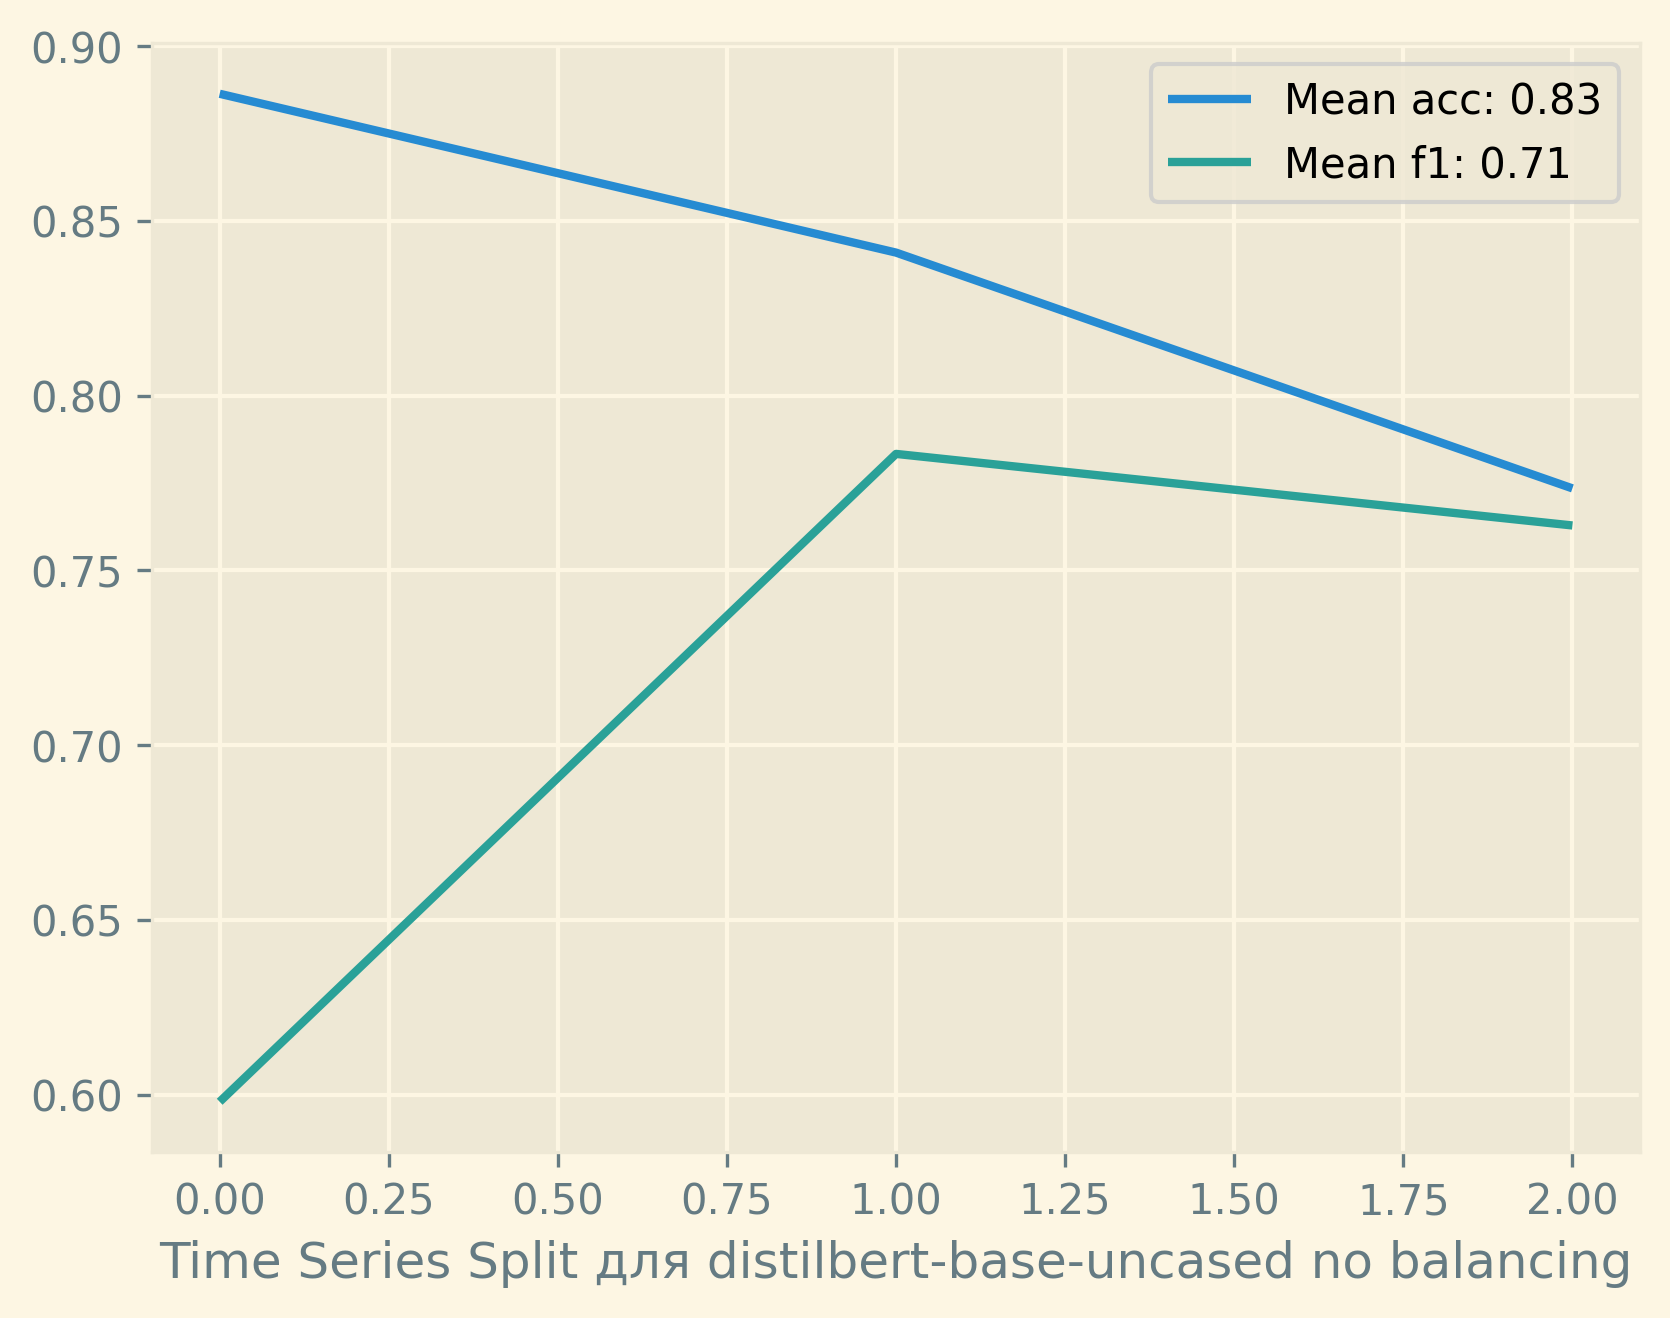

In [34]:
for model_name, metrics_dict in model_name_to_metrics_dict.items():
    for metric_name, metrics in metrics_dict.items():
        plt.plot(
            metrics,
            label=f"Mean {metric_name}: {np.mean(metrics):.2f}",
        )

    plt.legend()
    plt.xlabel(f"Time Series Split для {model_name} no balancing")
    plt.show()

In [ ]:
joblib.dump(pipeline, model_dir / "model.pkl")

['news_category_model.pkl']

In [29]:
pipeline = joblib.load(model_dir / "model.pkl")
pred_test = pipeline.predict(X_test)

Bert inference on 20953 texts:   0%|          | 0/210 [00:00<?, ?it/s]

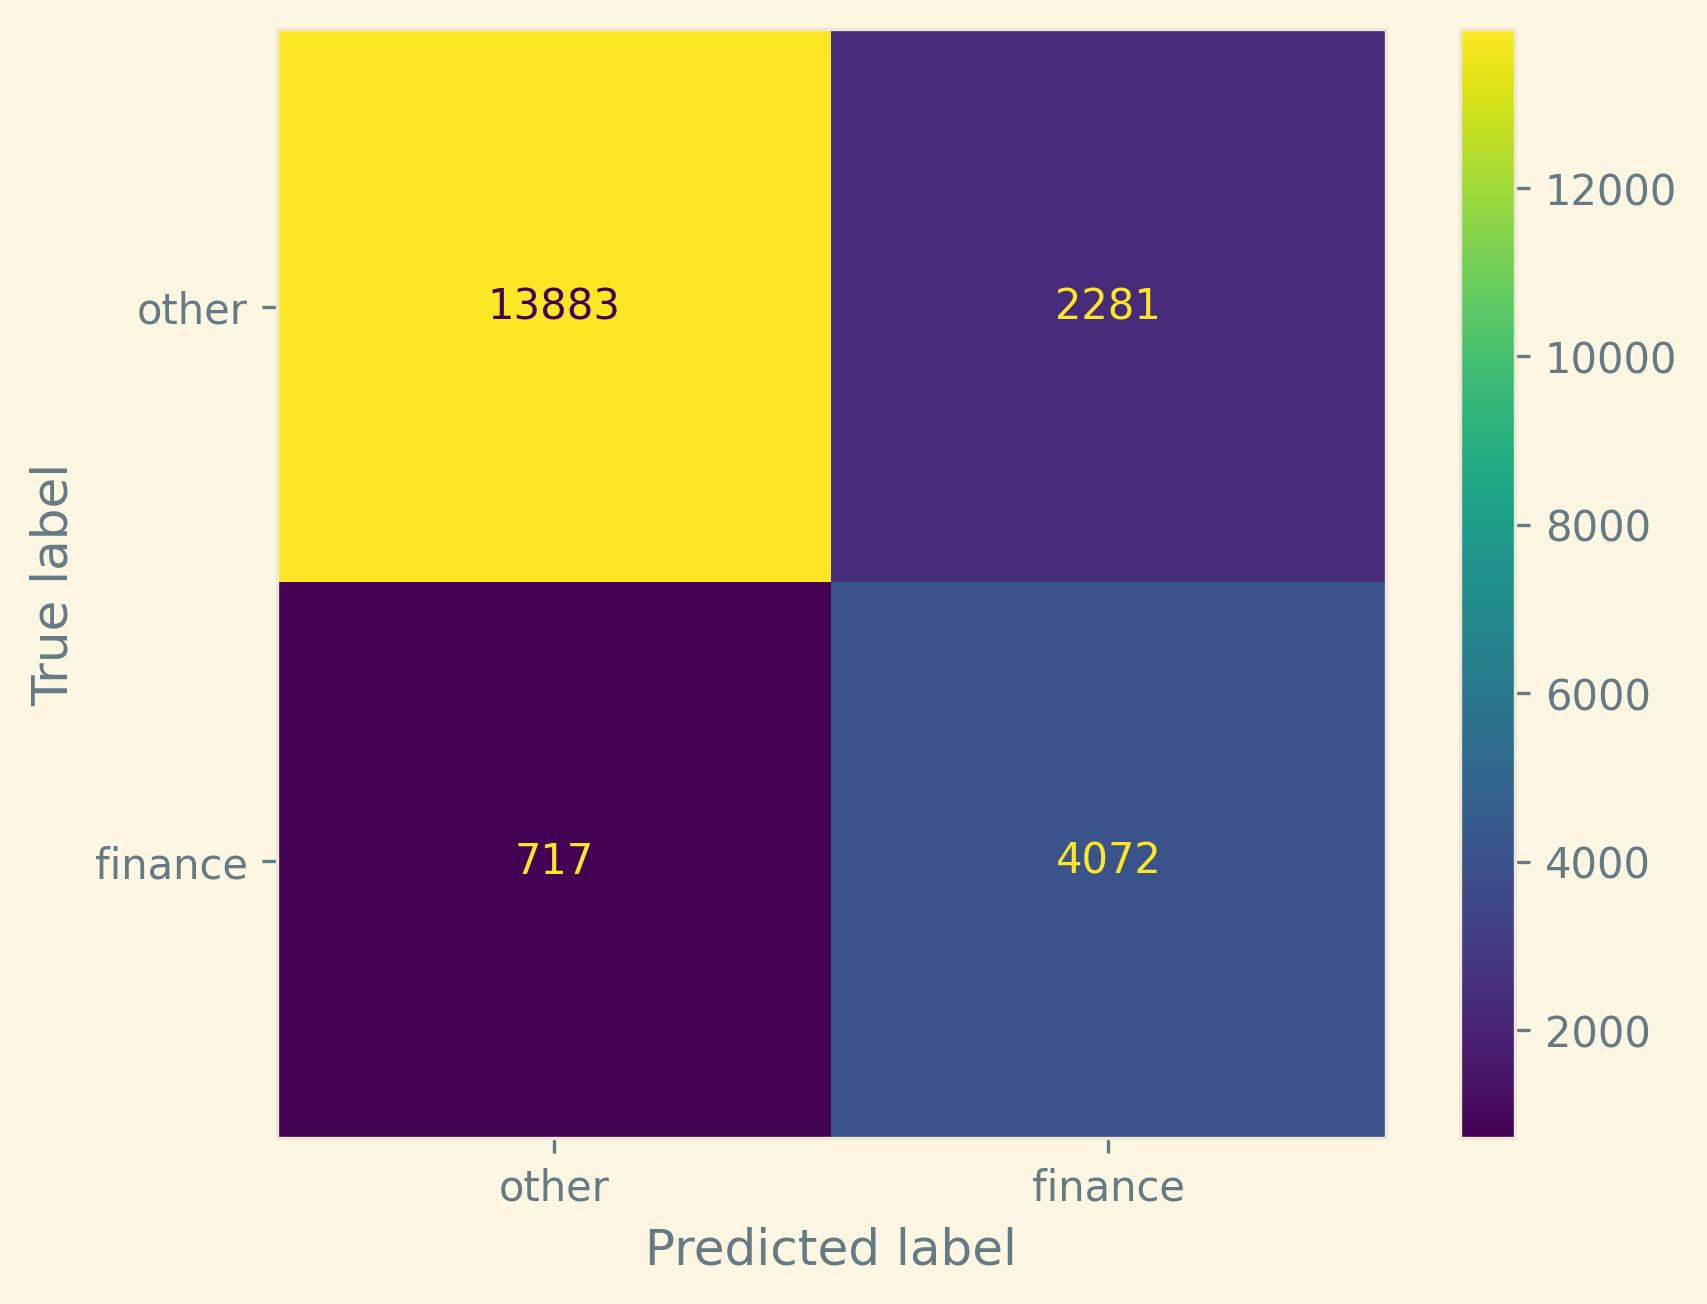

In [36]:
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix(y_test, pred_test),
    display_labels=label_to_id.keys(),
).plot()

confusion_matrix_display.ax_.grid(False)

## Oversample

In [54]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy="minority")

# data_sample = data.sample(1000, random_state=42)

X = data_sample[["text", "date"]]
y = data_sample["category"]

X, y = oversample.fit_resample(X, y)

X = X.sort_values("date")
y = y.loc[X.index]

In [55]:
bert_vectorizer = bert.BertVectorizer(
    bert_name="distilbert-base-uncased",
)
col_transformer = ColumnTransformer(
    [
        ("bert_vectorizer", bert_vectorizer, "text"),
    ]
)

model = LGBMClassifier(
    class_weight="balanced",
)

pipeline = Pipeline(
    [
        ("features", col_transformer),
        ("model", model),
    ]
)

model_name_to_metrics_dict = {}
model_name_to_metrics_dict["oversampled"] = train.train_and_cross_validate(pipeline, X, y)

Bert inference on 154142 texts: 100%|██████████| 1542/1542 [01:20<00:00, 19.06it/s]


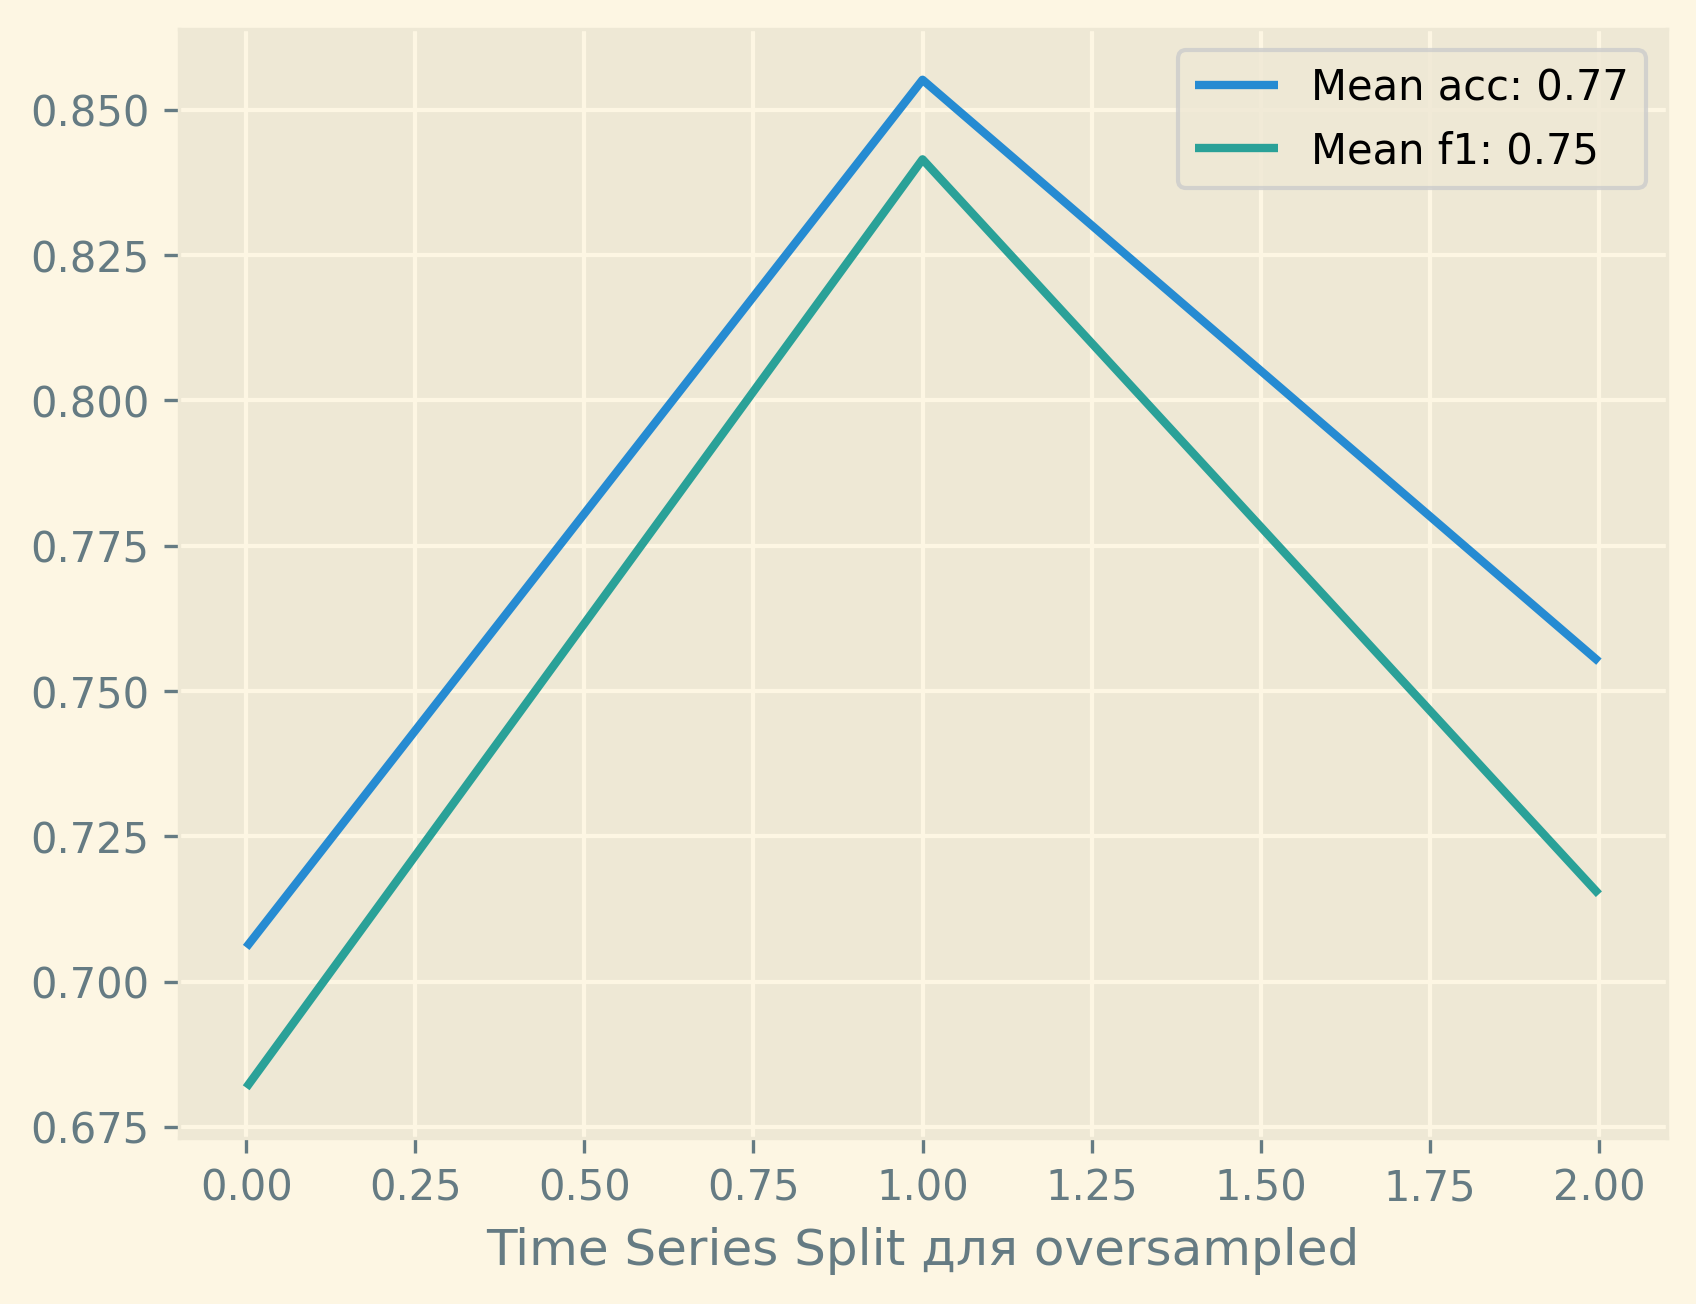

In [57]:
for model_name, metrics_dict in model_name_to_metrics_dict.items():
    for metric_name, metrics in metrics_dict.items():
        plt.plot(
            metrics,
            label=f"Mean {metric_name}: {np.mean(metrics):.2f}",
        )

    plt.legend()
    plt.xlabel(f"Time Series Split для {model_name}")
    plt.show()

## Bert finetuning

In [5]:
data_sample = data

X = data_sample[["text", "date"]]
y = data_sample["category"]

In [41]:
from torch.optim.lr_scheduler import MultiStepLR, ChainedScheduler
from focal_loss import FocalLoss

device = "cuda"

model = bert.BertFineTuned(
    num_classes=2,
    use_softmax_in_forward=True,
)

# criterion = torch.nn.CrossEntropyLoss()
criterion = FocalLoss(
    gamma=1,
    weights=torch.tensor([1 / 0.2, 1 / 0.8], device=device),
)

# scheduler = ChainedScheduler([
#     optim.WarmupScheduler(optimizer, warmup_steps=10),
#     MultiStepLR(optimizer, milestones=[29], gamma=0.5),
# ])

lr = 0.0005
epochs = 10
milestones = [5, 7]

# trainer = BertTrainer(
#     model,
#     optimizer,
#     criterion,
#     dataset_dict['train'],
#     dataset_dict['test'],
#     scheduler=scheduler,
# )
# trainer.train(epochs)

In [42]:
metrics_dict = bert.train_bert_and_cross_validate(
    model,
    epochs=epochs,
    X=X,
    y=y,
    criterion=criterion,
    lr=lr,
    milestones=milestones,
    device=device,
    split_type="time_series",
)

Training::   0%|          | 0/10 [00:00<?, ?it/s]

acc: 0.88
f1: 0.69


Training::   0%|          | 0/10 [00:00<?, ?it/s]

acc: 0.85
f1: 0.82


Training::   0%|          | 0/10 [00:00<?, ?it/s]

acc: 0.78
f1: 0.78


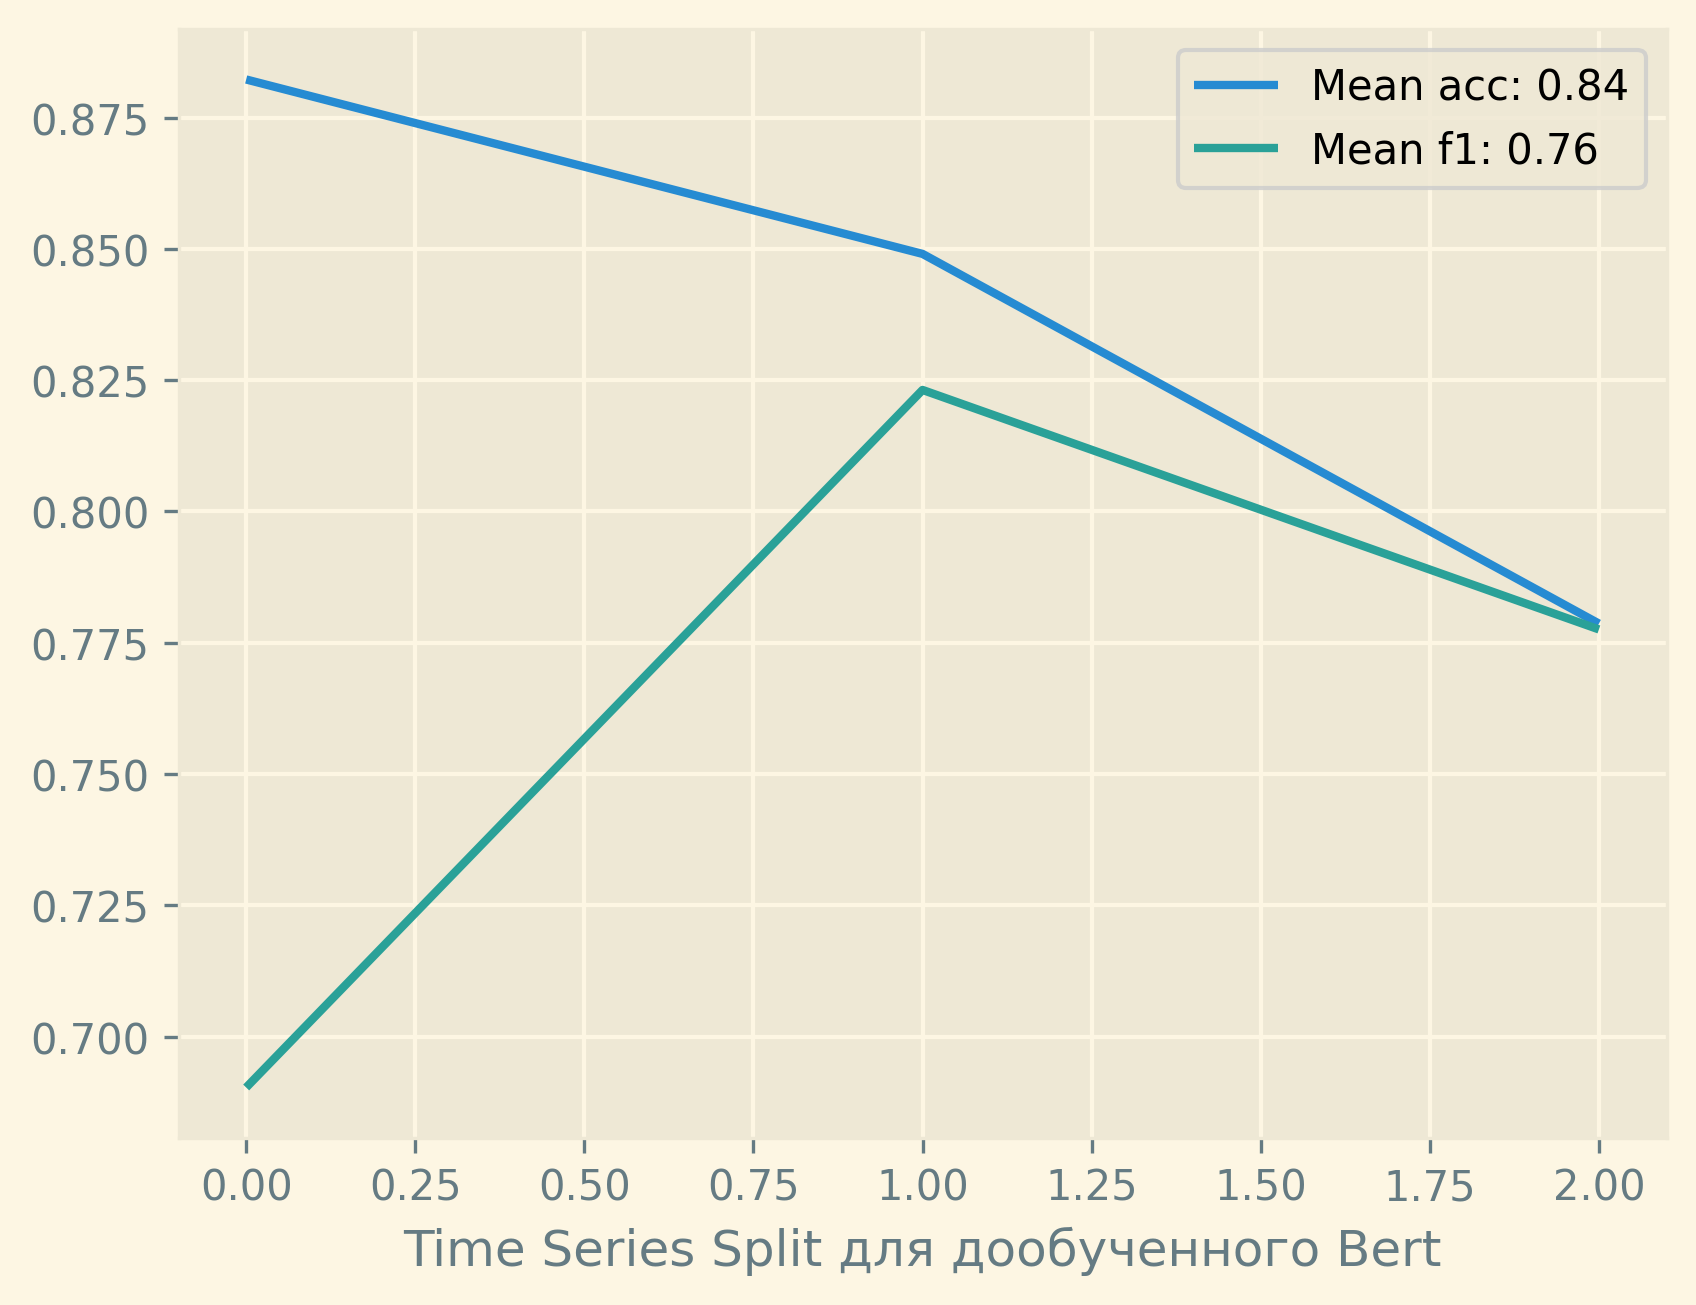

In [43]:
for metric_name, metrics in metrics_dict.items():
    plt.plot(
        metrics,
        label=f"Mean {metric_name}: {np.mean(metrics):.2f}",
    )

plt.legend()
plt.xlabel(f"Time Series Split для дообученного Bert")
plt.show()